# Variational EM for Latent Dirichlet Allocation

<div class="alert alert-success">
<strong>References</strong>
<ol>
    <li><a href=http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf>Blei, Ng, & Jordan (2003)</a></li>
    <li><a href=https://gytcrt.github.io/2016/05/02/topic-modeling-with-latent-dirichlet-allocation/>Topic Modeling with Latent Dirichlet Allocation (Gao & Liang)</a></li>
</ol>
Skip to the <a href=#Code>code</a>.
</div>

## Notation
- $W$: Observed data
- $D$: The total number of documents
- $N_d$: The number of words in document $d$
- $N$: The total number of unique words across all documents
- $T$: The total number of topics 


**Latent variables**
- $Z$: The latent topic assignments for each word
- $\theta$: Parameters for the document-topic distribution

**Variational parameters**
- $\phi$: Parameters for the variational multinomial approximation to $z$
- $\gamma$: Parameters for the variational Dirichlet approximation to $\theta$

**Model parameters**
- $\alpha$: Parameters for the Dirichlet prior on $\theta$
- $\beta$: Parameters for the multinomial topic-word distribution $W|Z$

**Parameterizations**
- $\theta_d \sim \text{Dir}(\alpha) $
- $z | \theta \sim \text{Multi}(\theta_d)$
- $w | z \sim \text{Multi}(\beta_z)$


- $p(z_{n} = t| \theta_d) = \theta_{d, \ t}$
- $p(w_n | z_n = t) = \beta_{t, \ w_{n}}$

**Variational Approximations**
- $q(z_n | \phi) = \text{Multi}(\phi_{n})$
- $q(\theta | \gamma) = \text{Dir}(\gamma)$


#### Dimensions

- $\alpha$: $T \times 1$
- $\beta$: $T \times N$ 
- $\theta$: $D \times T$
- $Z$: $D \times T \times N_d$
- $\phi$: $D \times T \times N_d$
- $\gamma$: $T \times D$

## Latent Dirichlet Allocation Model

<img src="images/lda.png" alt="Smiley face" width="70%">

$$
P(W, Z, \theta, \phi) = \prod_{d=1}^D p(\theta_d) \left[\prod_{n=1}^{N_d} p(z_{dn} | \theta_d) p(w_{dn} | z_{dn}, \beta_{z_{dn}})\right]
$$
---

Here's pseudocode for the generative model:
```
For each document d,
    Choose the topic distribution θ_d ~ Dirichlet(α)
    For each of the N_d words:
        Choose a topic z_n ~ Multinomial(θ_d)
        Then choose a word w_n ~ Multinomial(β_z)
```

### Inference
Given a corpus of documents, we'd like to find the model parameters $\alpha$ and $\beta$ that maximize the marginal log likelihood of the observed data, integrating/summing over the latent variables $\theta$ and $z$:

$$ \alpha^*, \beta^* = \arg \max_{\alpha, \beta} \log p(W | \alpha, \beta)$$

The standard approach to doing this is to use the Expectation-Maximization algorithm. In this approach, we iterate between:

- **E-Step**: Maximize the probability of the hidden variables, $\theta$ and $z$, given the observed data and current values for the model parameters: $p(\theta,z | W, \alpha, \beta)$. 
- **M-Step**: Using the estimates for the latent variables $\theta$ and $z$ found during the E-step, maximize the posterior distribution with respect to the model parameters $\alpha$ and $\beta$.

Unfortunately, computing the posterior over hidden variables, $p(\theta,z | W, \alpha, \beta)$ in the E-step is intractable for the LDA model. As a result, we must use an approximation: $q(\theta, z | \gamma, \phi)$. This approach is known as **variational EM**.

### Variational EM

<div class="alert alert-success">
<strong>Big Ideas</strong></br>
<ol>
   <li>We want to find an approximation, $q(\theta, z |\gamma, \phi)$, that is as close as possible to (i.e., has the minimal KL divergence to) the true model posterior, $p(\theta, Z|W,\alpha,\beta)$.</li>
    <li>Minimizing the KL divergence between $q(\theta, z |\gamma, \phi)$ and $p(\theta, z | W, \alpha, \beta)$ is equivalent to finding the variational parameters, $\phi$, and $\gamma$ that <em>maximize</em> a lower bound $\mathcal{L}(\gamma, \phi, \alpha,\beta)$ on the marginal likelihood, $p(w | \alpha, \beta)$.</li> 
</ol>
</div>

In variational inference, we consider a simplified graphical model with variational parameters $\gamma$ and $\phi$ and minimize the KL Divergence between the variational approximation, $q(\theta, z | \gamma, \phi)$ and the true posterior  $p(z, \theta |W, \alpha, \beta)$ during the E-step. 

We select the variational approximation to provide us with a lower bound on the marginal log likelihood, $\log p(W | \alpha, \beta)$. We can show that with the correct choice of lower bound, maximizing with respect to the variational parameters is equivalent to _minimizing_ the KL divergence between the variational lower bound and the model posterior, $p(\theta, z | W, \alpha, \beta)$.  

- **E-step**: Maximize the variational approximation to the model posterior with respect to the variational parameters: $$\begin{align*}
    \gamma^{(t)}, \phi^{(t)} &= \arg \min_{\gamma, \phi} \mathbb{KL} \left[ q(\theta^{(t-1)}, z^{(t-1)} | \gamma, \phi) \ || \ p(\theta, z | W, \alpha^{(t-1)}, \beta^{(t-1)}) \right] \\
    &= \arg \max_{\gamma, \phi} \mathcal{L}(\gamma, \phi, \alpha^{(t-1)}, \beta^{(t-1)})
\end{align*}$$.
- **M-step**: Maximize the variational approximation with respect to the model parameters, using the variational parameters identified during the E-step: $$ \alpha^{(t)}, \beta^{(t)} = \arg \max_{\alpha, \beta} \mathcal{L}(\gamma^{(t)}, \phi^{(t)}, \alpha, \beta)$$

### Deriving the variational bound
<div class="alert alert-success">
<strong>Big Ideas</strong><br>
The variational lower bound on the marginal log likelihood is 

$$\mathcal{L}(\gamma,\phi, \alpha,\beta) = \mathbb{E}_q[\log p(\theta | \alpha)] + \mathbb{E}_q[\log p(z|\theta)] + \mathbb{E}_q[\log p(w | z, \beta)] - \mathbb{E}_q[\log q(\theta, z)]$$

Maximizing the lower
bound with respect to $\gamma$ and $\phi$ is equivalent to minimizing the KL divergence between the
variational approximation to the posterior and the true posterior.
</div>

\begin{align*}
    \log p(w | \alpha, \beta) &= \log \int \sum_{t=1}^T p(w, \theta, z=t | \alpha, \beta) d\theta\\
    &= \log \int \sum_{t=1}^T \frac{q(\theta, z=t)}{q(\theta, z=t)} p(w, \theta, z=t | \alpha, \beta) d\theta\\
    &= \log \mathbb{E}_q \left[ \frac{p(w, \theta, z | \alpha, \beta)}{q(\theta, z)} \right]\\
    &\geq \mathbb{E}_q \left[ \log \frac{p(w, \theta, z | \alpha, \beta)}{q(\theta, z)} \right]\\
    &=\mathbb{E}_q [\log p(w, \theta, z | \alpha, \beta)] - \mathbb{E}_q[\log q(\theta, z)]\\
    &= \mathbb{E}_q[\log p(\theta | \alpha)] + \mathbb{E}_q[\log p(z|\theta)] + \mathbb{E}_q[\log p(w | z, \beta)] - \mathbb{E}_q[\log q(\theta, z)]
\end{align*}

Thus, we have that our variational lower bound on the marginal log likelihood is 

$$
\mathcal{L}(\gamma,\phi, \alpha,\beta) = \mathbb{E}_q[\log p(\theta | \alpha)] + \mathbb{E}_q[\log p(z|\theta)] + \mathbb{E}_q[\log p(w | z, \beta)] - \mathbb{E}_q[\log q(\theta, z)]
$$
---

Further, we can show that the difference between $\log p(w | \alpha, \beta)$ and $\mathcal{L}(\gamma,\phi, \alpha,\beta)$ is exactly equal to $\mathbb{KL}[q(\theta, z|\gamma, \phi) \ || \ p(z, \theta | w, \alpha,\beta)]$ (see EM algorithm notes for details). As a result, we have that maximizing the lower
bound with respect to $\gamma$ and $\phi$ is equivalent to minimizing the KL divergence between the
variational approximation to the posterior and the true posterior.

---

### Mean field approximation
One standard choice for the variational family, $q$, is the **mean field approximation**. Under this family, we assume the variational distribution $q$ over the latent variables $z$ and $\theta$ factorizes into the product of independent  distributions, each controlled by separate variational paramters $\gamma$ and $\phi$:

$$q(\theta, Z|\gamma,\phi) = \prod_D q(\theta_d | \gamma) \prod_N q(z_{dn} | \phi)$$

For the LDA model, we'll use the following forms for the factored variational distributions:

\begin{align*}
    q(z_n | \phi) &= \text{Multi}(\phi_{n})\\
    q(\theta_d | \gamma) &= \text{Dir}(\gamma)
\end{align*}


### Expanding each term in $\mathcal{L}$
All expansions are relative to a given document, $d$. A few useful facts:

$$
\text{Dir}(\alpha) = \frac{\Gamma\left( \sum_{i=1}^K \alpha_i \right)}{\prod_{i=1}^K \Gamma(\alpha_i)} \prod_{i=1}^K x_i^{\alpha_i - 1}
$$

and

\begin{align}
    \text{For }&X \sim \text{Dir}(\gamma)\\
    \mathbb{E}[\log X_i] &= \Psi(\gamma_i) - \Psi(\sum_k \gamma_k)
\end{align}

where $\Psi$ is the [digamma function](https://en.wikipedia.org/wiki/Digamma_function):

$$
\Psi(x) = \frac{\Gamma'(x)}{\Gamma(x)} = \frac{d}{dx} \log \Gamma(x)
$$

---

\begin{align*}
\mathbb{E}_q[\log p(\theta | \alpha)] &= \int \sum_z q(\theta, z| \gamma, \phi) \log \text{Dir}(\alpha) \ d\theta \\
&= \int \sum_z q(\theta, z| \gamma, \phi) \log \left[ \frac{\Gamma(\sum_{t=1}^T \alpha_t)}{\prod_{t=1}^T \Gamma(\alpha_t)} \prod_{t=1}^T \theta_t^{(\alpha_t - 1)} \right] \ d\theta\\
&= \int \sum_z q(\theta, z| \gamma, \phi) \left[\log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \sum_{t=1}^T (\alpha_t - 1) \log \theta_t \right] \ d\theta\\
&= \log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \int \sum_z q(\theta, z| \gamma, \phi) \sum_{t=1}^T (\alpha_t - 1) \log \theta_t \ d\theta \\
&= \log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \sum_{t=1}^T (\alpha_t - 1) \int \sum_z q(\theta, z| \gamma, \phi) \log \theta_t \ d\theta \\
&= \log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \sum_{t=1}^T (\alpha_t - 1) \int q(\theta| \gamma)  \log \theta_t \sum_z q(z|\phi) \ d\theta \\
&= \log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \sum_{t=1}^T (\alpha_t - 1) \int q(\theta| \gamma)  \log \theta_t \ d\theta\\
&= \log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \sum_{t=1}^T (\alpha_t - 1) \mathbb{E}_q[\log \theta_t] \\
&= \log \Gamma(\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) + \sum_{t=1}^T (\alpha_t - 1) \left(\Psi(\gamma_t) - \Psi( \sum_{t=1}^T \gamma_t)\right)
\end{align*}

---

\begin{align*}
\mathbb{E}_q[\log p(z=t|\theta)] &= \int \sum_z q(\theta, z) \log p(z | \theta) \ d\theta \\
&= \int \sum_{z} q(\theta, z) \sum_{n=1}^{N_d} \sum_{t=1}^T \log p(z_n = t | \theta) \ d\theta \\
&= \int \sum_{z} q(\theta, z)\sum_{n=1}^{N_d} \sum_{t=1}^T [z_n = t] \log \theta_{t} \ d\theta \\
&= \mathbb{E}_q \left[\sum_{n=1}^{N_d} \sum_{t=1}^T [z_n = t] \log \theta_t \right]\\
&= \sum_{n=1}^{N_d} \sum_{t=1}^T \mathbb{E}_q \left[ [z_n = t] \log \theta_t \right] &&\text{By linearity of expectation}\\
&= \sum_{n=1}^{N_d} \sum_{t=1}^T \mathbb{E}_{q(z)} \left[ z_n = t \right] \mathbb{E}_{q(\theta)}\left[ \log \theta_t \right] &&\text{$q(z)$ and $q(\theta)$ are independent under mean field approx.}\\
&= \sum_{n-1}^{N_d} \sum_{t=1}^T \phi_{t, n} \left( \Psi(\gamma_t) - \Psi(\sum_k \gamma_k) \right)
\end{align*}

---
\begin{align*}
\mathbb{E}_q [\log p(w | z, \beta) ] &= \int \sum_z q(z, \theta) \log p(w | z, \beta) \ d\theta\\
&= \int \sum_z q(z, \theta) \sum_{n=1}^{N_d} \log p(w_n | z_n, \beta) \ d\theta\\
&= \int \sum_z q(z, \theta) \sum_{n=1}^{N_d} [z_n = t] \log \beta_{t, \ w_{n}} \ d\theta\\
&= \mathbb{E}_q \left[ \sum_{n=1}^{N_d} [z_n = t] \log \beta_{t, \ w_n} \right]\\
&= \sum_{n=1}^{N_d} \mathbb{E}_q [ [z_n = t] \log \beta_{t, \ w_n} ]\\
&= \sum_{n=1}^{N_d} \mathbb{E}_q [ z_n = t ] \mathbb{E}_q [\log \beta_{t, \ w_n} ]\\
&= \sum_{n=1}^{N_d} \phi_{t, n} \mathbb{E}_q [\log \beta_{t, \ w_n} ]\\
&= \sum_{n=1}^{N_d} \phi_{t, n} \log \beta_{t, \ w_n} &&\text{Since $\beta_{t, \ w_n}$ doesn't depend on $\theta$ or $z$}\\
\end{align*}

---

\begin{align*}
\mathbb{E}_q [ \log q(\theta, z) ] &= \mathbb{E}_q [\log q(\theta) + \log q(z) ] \\
&= \mathbb{E}_{q(\theta)} [ \log q(\theta) ] + \mathbb{E}_{q(z)} [ \log q(z)] &&\text{By linearity of expectation}\\
&= \int q(\theta) \log q(\theta) \ d\theta + \sum_z q(z) \log q(z)\\
&= \int q(\theta) \log \text{Dir}(\gamma) \ d\theta + \sum_z q(z) \log \text{Dir}(\phi)\\
&= \int q(\theta) \left[ \log \Gamma \left(\sum_{i=1}^T \gamma_i \right) - \sum_{i=1}^T \log \Gamma(\gamma_i) + \sum_{i=1}^T (\gamma_i - 1) \log \theta_i  \right]\  d\theta + \sum_{t=1}^T \sum_{n=1}^{N_d} \phi_{t, n} \log \phi_{t, n}\\
&= \log \Gamma \left(\sum_{i=1}^T \gamma_i \right) - \sum_{i=1}^T \log \Gamma(\gamma_i) + \sum_{i=1}^T (\gamma_i - 1) \int q(\theta) \log \theta_i \  d\theta + \sum_{t=1}^T \sum_{n=1}^{N_d} \phi_{t, n} \log \phi_{t, n}\\
&= \log \Gamma \left(\sum_{i=1}^T \gamma_i \right) - \sum_{i=1}^T \log \Gamma(\gamma_i) + \sum_{i=1}^T (\gamma_i - 1) \mathbb{E}_q[ \log \theta_i ] + \sum_{t=1}^T \sum_{n=1}^{N_d} \phi_{t, n} \log \phi_{t, n}\\
&= \log \Gamma \left(\sum_{i=1}^T \gamma_i \right) - \sum_{i=1}^T \log \Gamma(\gamma_i) + \sum_{i=1}^T (\gamma_i - 1) \left( \Psi(\gamma_i) - \Psi(\sum_k \gamma_k) \right) + \sum_{t=1}^T \sum_{n=1}^{N_d} \phi_{t, n} \log \phi_{t, n}\\
\end{align*}

---

## E-Step
<div class="alert alert-success">
<strong>Big Ideas</strong><br>
The updates to the variational parameters during the E-step are:<br>
<br>
\begin{align}
    \phi_{t, n} &\propto \beta_{t, \ w_n} \exp \left\{ \Psi(\gamma_t) \right\}\\
    \gamma_t &= \alpha_t + \sum_{n=1}^{N_d} \phi_{t, n}    
\end{align}

</div>

During the E-step, we are interested in maximizing our lower bound $\mathcal{L}$ with respect to the variational parameters, $\gamma$ and $\phi$:

$$
\gamma^*, \phi^* = \arg \max_{\gamma, \phi} \mathcal{L}(\gamma, \phi, \alpha^{(t-1)}, \beta^{(t-1)})
$$

Now that we've written out each term of $\mathcal{L}$ for the LDA model, we can go about differentiating with respect to $\phi$ and $\gamma$, setting each to 0, and solving for the optimal paramters.

#### Update for $\phi$
Begin by writing out the components of $\mathcal{L}$ that depend on $\phi$:

\begin{align*}
    \mathcal{L}_\phi &=  \sum_{n-1}^{N_d} \sum_{t=1}^T \phi_{t, n} \left( \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) \right) + \sum_{n=1}^{N_d} \phi_{t, n} \log \beta_{t, \ w_n} - \sum_{t=1}^T \sum_{n=1}^{N_d} \phi_{t, n} \log \phi_{t, n}\\
\end{align*}

Note that $\phi$ represents probabilities such that $\sum_{t = 1}^T \phi_{t, n} = 1$. Because of this constraint, we will use Lagrange multipliers, introducing a constraint term with weight $\lambda_n$:

\begin{align*}
    \mathcal{L}_\phi &=  \sum_{n-1}^{N_d} \sum_{t=1}^T \phi_{t, n} \left( \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) \right) + \sum_{n=1}^{N_d} \phi_{t, n} \log \beta_{t, \ w_n} - \sum_{t=1}^T \sum_{n=1}^{N_d} \phi_{t, n} \log \phi_{t, n} + \lambda_n \left( \sum_{t=1}^T \phi_{t, n} - 1 \right)\\
\end{align*}

Now we differentiate with respect to $\phi_{t, n}$:

\begin{align*}
    \frac{\partial \mathcal{L}}{\partial \phi_{t, n}} &= \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) + \log \beta_{t, \ w_n} - \log \phi_{t, n} - 1 + \lambda_n
\end{align*}
and set this term to 0:

\begin{align*}
0 &= \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) + \log \beta_{t, \ w_n} - \log \phi_{t, n} - 1 + \lambda_n\\
\log \phi_{t, n} &= \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) + \log \beta_{t, \ w_n} - 1 + \lambda_n\\
\phi_{t, n} &= \exp \left\{ \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) + \log \beta_{t, \ w_n} - 1 + \lambda_n \right\}\\
\phi_{t, n} &= \beta_{t, \ w_n} \exp \left\{ \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) - 1 + \lambda_n \right\}\\
\phi_{t, n} &= \beta_{t, \ w_n} \frac{\exp \left\{ \Psi(\gamma_t) + \lambda_n \right\} }{\exp \left\{1 +  \Psi(\sum_T \gamma_t) \right\}}\\
\phi_{t, n} &\propto \beta_{t, \ w_n} \exp \left\{ \Psi(\gamma_t) + \lambda_n \right\}\\
\end{align*}

Note that $\lambda_n$ is constant for all topics $t$, and thus we can absorb it into the proportionality constant when computing $\phi_{t, n}$. Hence we have

$$\phi_{t, n} \propto \beta_{t, \ w_n} \exp \left\{ \Psi(\gamma_t) \right\}$$

#### Update for $\gamma$
Begin by writing out the components of $\mathcal{L}$ that depend on $\gamma$:

$$ 
    \mathcal{L}_\gamma = \sum_{t=1}^T (\alpha_t - 1) \left(\Psi(\gamma_t) - \Psi(\sum_{t=1}^T \gamma_t)\right) + \sum_{n=1}^{N_d} \sum_{t=1}^T \phi_{t, n} \left( \Psi(\gamma_t) - \Psi( \sum_k \gamma_k) \right) - \log \Gamma \left(\sum_{i=1}^T \gamma_i \right) + \sum_{t=1}^T \log \Gamma(\gamma_t) - \sum_{t=1}^T (\gamma_t - 1) \left( \Psi(\gamma_t) - \Psi(\sum_T \gamma_t) \right)
$$

Now we differentiate with respect to $\gamma_{t}$:

\begin{align*}
    \frac{\partial \mathcal{L}}{\partial \gamma_t} &= (\alpha_t - 1) \left(\Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t)\right) + \sum_{n=1}^{N_d} \phi_{t, n}\left(\Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t)\right) - \Psi(\sum_{i=1}^T \gamma_i) + \Psi(\gamma_t) - (\gamma_t - 1) \left( \Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t) \right) - \Psi(\gamma_t) + \Psi(\sum_T \gamma_t)\\
    &= (\alpha_t - 1) \left(\Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t)\right) + \sum_{n=1}^{N_d} \phi_{t, n}\left(\Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t)\right)- (\gamma_t - 1) \left( \Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t) \right) \\
    &= \left(\Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t)\right) \left[ (\alpha_t - 1) + \sum_{n=1}^{N_d} \phi_{t, n} - (\gamma_t - 1) \right]
\end{align*}

and set this expression to 0:

\begin{align*}
    0 &= \left(\Psi'(\gamma_t) - \Psi'(\sum_T \gamma_t)\right) \left[ (\alpha_t - 1) + \sum_{n=1}^{N_d} \phi_{t, n} - (\gamma_t - 1) \right]\\
\end{align*}

We'll focus on the expression on the right hand side:

\begin{align*}
    0 &= (\alpha_t - 1) + \sum_{n=1}^{N_d} \phi_{t, n} - (\gamma_t - 1)\\
    &= \alpha_t - \gamma_t + \sum_{n=1}^{N_d} \phi_{t, n}\\
    \gamma_t &= \alpha_t + \sum_{n=1}^{N_d} \phi_{t, n}
\end{align*}

---

## M-Step
<div class="alert alert-success">
<strong>Big Ideas</strong><br>
The updates to the model parameters during the M-step are:<br>
<br>
\begin{align}
     \beta_{t, n}^* &\propto \sum_{d=1}^D \sum_{i=1}^{N_d}\phi_{d, t, n} [ i = n] \\
     \alpha_{t} &= \text{No closed form expression. Use Newton-Raphson}
\end{align}

</div>

During the M-step, we are interested in maximizing our lower bound $\mathcal{L}$ with respect to the model parameters, $\alpha$ and $\beta$:

$$
\alpha^*, \beta^* = \arg \max_{\alpha, \beta} \mathcal{L}(\gamma^{(t)}, \phi^{(t)}, \alpha, \beta)
$$

where $\gamma^{(t)}$ and $\phi^{(t)}$ are the variational parameters identified during the E-step. 

#### Update for $\beta$

Begin by writing out the components of $\mathcal{L}$ that depend on $\beta$:

$$
\mathcal{L}_\beta = \sum_{n=1}^{N_d} \phi_{t, n} \log \beta_{t, \ w_n}
$$

Note that $\beta$ is a probability distribution and we have that $\sum_{n=1}^{N_d} \beta_{t, \ n} = 1$. As a result, we incorporate Lagrange multipliers with weights $\rho$:

$$
\mathcal{L}_\beta = \sum_{d=1}^D \sum_{n=1}^{N_d} \phi_{d, t, n} \log \beta_{t, \ n} + \sum_{t=1}^T \rho_t \sum_{n=1}^{N_d} \beta_{t, \ n} - 1
$$

Differentiating with respect to $\beta_{t, n}$ gives us:

\begin{align*}
    \frac{\partial \mathcal{L}}{\partial \beta_{t, n}} &=  \frac{\sum_{d=1}^D \sum_{i=1}^{N_d}\phi_{d, t, n} [ i = n]}{\beta_{t,n}} + \rho_t
\end{align*}
Setting this to 0 and solving for $\rho_t$ yields:

\begin{align*}
    \rho_i = −\sum_{d, t, i} \phi_{d, t, n} [ i = n]
\end{align*}

However, because we know that $\sum_{n=1}^{N_d} \beta_{t, \ n} = 1$, we can ignore $\rho_i$ and calculate the unnormalized expression for $\beta_{t, n}^*$:

$$
\beta_{t, n}^* \propto \sum_{d=1}^D \sum_{i=1}^{N_d}\phi_{d, t, n} [ i = n]
$$

#### Update for $\alpha$

Begin by writing out the components of $\mathcal{L}$ that depend on $\alpha$:

$$
\mathcal{L}_\alpha = \sum_{d=1}^D \left( \sum_{t=1}^T (\alpha_t - 1)(\Psi(\gamma_{d, t} ) - \Psi(\sum_{t=1}^T \gamma_{d, t} ) ) + \log \Gamma (\sum_{t=1}^T \alpha_t) - \sum_{t=1}^T \log \Gamma(\alpha_t) \right)
$$

Differentiating with respect to $\alpha_t$ yields:

\begin{align*}
    \frac{\partial \mathcal{L}}{\partial \alpha_t} &= \sum_{d=1}^D \left(\Psi(\gamma_{d, t} ) - \Psi(\sum_{t=1}^T \gamma_{d, t} ) \right) + D \left( \Psi(\sum_{t=1}^T \alpha_t) - \Psi(\alpha_t) \right)
\end{align*}

Unfortunately, this derivative indicates that the optimal value for $\alpha_t$ depends on the values of the other $\alpha_j$ for $j \neq t$. Blei et al. propose an iterative method to maximize $\alpha_t$ based on the [Newton-Raphson algorithm](https://en.wikipedia.org/wiki/Newton%27s_method), noting that because the Hessian of the above expression is a matrix of the form:

$$
H = \text{diag}(h) + \mathbf{1}z\mathbf{1}^\top
$$
where

\begin{align*}
    h &= -D \Psi'(\alpha)\\
    z &= D \Psi'(\sum_{t=1}^T \alpha_t )
\end{align*}

its inverse can be written as

$$
H^{-1} = \text{diag}(h)^{-1} = \frac{\text{diag}(h)^{-1} \mathbf{11}^\top \text{diag}(h)^{-1}}{z^{-1} \sum_{t=1}^{T}h_t^{-1}}
$$

and we can compute the stable point for $\alpha_t$ using $O(n)$ operations rather than the traditional $O(n^3)$ required when inverting Hessians in general.

---

# Python Implementation

In [68]:
import numpy as np
from scipy.special import digamma, polygamma, gammaln

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [74]:
def dg(gamma, d, t):
    """
    E[log X_t] where X_t ~ Dir
    """
    return digamma(gamma[d, t]) - digamma(np.sum(gamma[d, :]))

Below, we generate a fake dataset for validating our model.

In [75]:
np.random.seed(8675309)

# Generate some fake data
D = 300
T = 10
V = 30
N = np.random.randint(150, 200, size=D)

# Create a document-topic distribution for 3 different types of documents
alpha1 = np.array((20, 15, 10, 1, 1, 1, 1, 1, 1, 1))
alpha2 = np.array((1, 1, 1, 10, 15, 20, 1, 1, 1, 1))
alpha3 = np.array((1, 1, 1, 1, 1, 1, 10, 12, 15, 18))

# Arbitrarily choose each topic to have 3 very common, diagnostic words
# These words are barely shared with any other topic
beta_probs = np.ones((V, T)) + np.array([np.arange(V) % T == t for t in range(T)]).T * 19
beta_gen = np.array(list(map(lambda x: np.random.dirichlet(x), beta_probs.T))).T

corpus = []
theta = np.empty((D, T))

# Generate each document from the LDA model
for d in range(D):
    
    # Draw topic distribution for the document
    if d < (D / 3):
        theta[d, :] = np.random.dirichlet(alpha1, 1)[0]
    elif d < 2 * (D / 3):
        theta[d, :] = np.random.dirichlet(alpha2, 1)[0]
    else:
        theta[d, :] = np.random.dirichlet(alpha3, 1)[0]
        
    doc = np.array([])
    for n in range(N[d]):
        # Draw a topic according to the document's topic distribution
        z_n = np.random.choice(np.arange(T), p=theta[d, :])
        
        # Draw a word according to the topic-word distribution
        w_n = np.random.choice(np.arange(V), p=beta_gen[:, z_n])
        doc = np.append(doc, w_n)
        
    corpus.append(doc)

Now we define the LDA model:

In [70]:
class LDA(object):
    """
    Vanilla (non-smoothed) LDA model trained using variational EM.
    Generates maximum-likelihood estimates for model paramters 
    `alpha` and `beta`.
    
    T : int
        Number of topics
        
    D : int
        Number of documents
        
    N : int
        Number of words in each document
        
    V : int
        Number of unique word tokens across all documents
    
    phi : array of shape D x N[d] x T
        Variational approximation to word-topic distribution
        
    gamma : array of shape D x T
        Variational approximation to document-topic distribution
        
    alpha : array of shape 1 x T
        Parameter for the Dirichlet prior on the document-topic distribution
        
    beta  : array of shape V x T
        Word-topic distribution
    """
    
    def __init__(self, T=10):
        self.T = T
    
    def _maximize_phi(self):
        """
        Optimize variational parameter phi
        ϕ_{t, n} ∝ β_{t, w_n}  e^( Ψ(γ_t) )
        """
        D = self.D
        N = self.N
        T = self.T
        
        phi   = self.phi
        beta  = self.beta
        gamma = self.gamma
        corpus = self.corpus
        
        for d in range(D):
            for n in range(N[d]):
                for t in range(T):
                    w_n = int(corpus[d][n])
                    phi[d][n, t] = beta[w_n, t] * np.exp(dg(gamma, d, t))

                # Normalize over topics
                phi[d][n, :] = phi[d][n, :] / np.sum(phi[d][n, :])
        return phi

    def _maximize_gamma(self):
        """
        Optimize variational parameter gamma
        γ_t = α_t + \sum_{n=1}^{N_d} ϕ_{t, n}    
        """
        D = self.D
        phi   = self.phi
        alpha = self.alpha
        
        gamma = np.tile(alpha, (D, 1)) + np.array(list(map(lambda x: np.sum(x, axis=0), phi)))
        return gamma

    def _maximize_beta(self):
        """
        Optimize model parameter beta
        β_{t, n} ∝ \sum_{d=1}^D \sum_{i=1}^{N_d} ϕ_{d, t, n} [ i = n]
        """
        T = self.T
        V = self.V

        phi    = self.phi
        corpus = self.corpus
        
        for n in range(V):
            # Construct binary mask [i == n] to be the same shape as phi
            mask = [np.tile((doc == n), (T, 1)).T for doc in corpus]
            beta[n, :] = np.sum(np.array(list(map(lambda x: np.sum(x, axis=0), phi * mask))), axis=0)

        # Normalize over words
        for t in range(T):
            beta[:, t] = beta[:, t] / np.sum(beta[:, t])

        return beta

    def _maximize_alpha(self, max_iters=1000, tol=0.1):
        """
        Optimize alpha using Blei's O(n) Newton-Raphson modification 
        for a Hessian with special structure
        """
        D = self.D
        T = self.T
        
        alpha = self.alpha
        gamma = self.gamma

        for _ in range(max_iters):
            alpha_old = alpha

            #  Calculate gradient 
            g = D * (digamma(np.sum(alpha)) - digamma(alpha)) + \
                np.sum(digamma(gamma) - np.tile(digamma(np.sum(gamma, axis=1)), (T, 1)).T, axis=0)

            #  Calculate Hessian diagonal component
            h = -D * polygamma(1, alpha)

            #  Calculate Hessian constant component
            z = D * polygamma(1, np.sum(alpha))

            #  Calculate constant
            c = np.sum(g / h) / (z**(-1.0) + np.sum(h**(-1.0)))

            #  Update alpha
            alpha = alpha - (g - c) / h

            #  Check convergence
            if np.sqrt(np.mean(np.square(alpha - alpha_old))) < tol:
                break

        return alpha

    def _E_step(self):
        """
        Maximize the VLB with respect to the variational parameters, γ and ϕ
        """
        self.phi   = self._maximize_phi()
        self.gamma = self._maximize_gamma()
    
    def _M_step(self):
        """
        Maximize the VLB with respect to the model parameters, α and β
        """
        self.beta  = self._maximize_beta()
        self.alpha = self._maximize_alpha()
        
    def VLB(self):
        """
        Variational lower bound
        """
        phi    = self.phi
        alpha  = self.alpha
        beta   = self.beta
        gamma  = self.gamma
        corpus = self.corpus
       
        D = self.D
        T = self.T
        N = self.N
        
        a, b, c, _d = 0, 0, 0, 0
        for d in range(D):
            a += gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + \
                np.sum([(alpha[t] - 1) * dg(gamma, d, t) for t in range(T)])
            
            _d += gammaln(np.sum(gamma[d, :])) - np.sum(gammaln(gamma[d, :])) + \
                np.sum([(gamma[d, t] - 1) * dg(gamma, d, t) for t in range(T)])
                
            for n in range(N[d]):
                w_n = int(corpus[d][n])
                
                b += np.sum([phi[d][n, t] * dg(gamma, d, t) for t in range(T)])
                c += np.sum([phi[d][n, t] * np.log(beta[w_n, t]) for t in range(T)])
                _d += np.sum([phi[d][n, t] * np.log(phi[d][n, t]) for t in range(T)])
                
        return a + b + c - _d
    
    def initialize_parameters(self):
        """
        Provide reasonable initializations for model and variational parameters
        """
        T = self.T
        V = self.V
        N = self.N
        D = self.D
                
        # initialize model parameters
        self.alpha = 100 * np.random.dirichlet(10 * np.ones(T), 1)[0]
        self.beta = np.random.dirichlet(np.ones(V), T).T

        # initialize variational parameters
        self.phi = np.array([1 / T * np.ones([N[d], T]) for d in range(D)])
        self.gamma = np.tile(alpha, (D, 1)) + np.tile(N / T, (T, 1)).T        
    
    def train(self, corpus, verbose=False, max_iter=1000, tol=5):
        """
        Train the LDA model on a corpus of documents (bags of words).
        """
        self.D = len(corpus)
        self.V = len(set(np.concatenate(corpus)))
        self.N = np.array([len(d) for d in corpus])
        self.corpus = corpus

        self.initialize_parameters()
        vlb = -np.inf
        
        for i in range(max_iter):
            old_vlb = vlb
            
            self._E_step()
            self._M_step()
            
            vlb = self.VLB()
            delta = vlb - old_vlb
            
            if verbose:
                print('Iteration {}: {:.3f} (delta: {:.2f})'
                      .format(i + 1, vlb, delta))
                
            if delta < tol:
                break

Now, to train the model:

In [71]:
L = LDA(10)
L.train(corpus, verbose=True)

Iteration 1: -178732.015 (delta: inf)
Iteration 2: -177905.947 (delta: 826.07)
Iteration 3: -177770.789 (delta: 135.16)
Iteration 4: -177660.543 (delta: 110.25)
Iteration 5: -177552.810 (delta: 107.73)
Iteration 6: -177430.731 (delta: 122.08)
Iteration 7: -177272.880 (delta: 157.85)
Iteration 8: -177046.321 (delta: 226.56)
Iteration 9: -176697.542 (delta: 348.78)
Iteration 10: -176146.280 (delta: 551.26)
Iteration 11: -175302.602 (delta: 843.68)
Iteration 12: -174134.059 (delta: 1168.54)
Iteration 13: -172738.643 (delta: 1395.42)
Iteration 14: -171276.804 (delta: 1461.84)
Iteration 15: -169796.186 (delta: 1480.62)
Iteration 16: -168306.251 (delta: 1489.94)
Iteration 17: -166995.883 (delta: 1310.37)
Iteration 18: -166074.624 (delta: 921.26)
Iteration 19: -165527.052 (delta: 547.57)
Iteration 20: -165214.430 (delta: 312.62)
Iteration 21: -165029.100 (delta: 185.33)
Iteration 22: -164911.572 (delta: 117.53)
Iteration 23: -164830.596 (delta: 80.98)
Iteration 24: -164770.595 (delta: 60.00)


Text(0.5,1,'Beta')

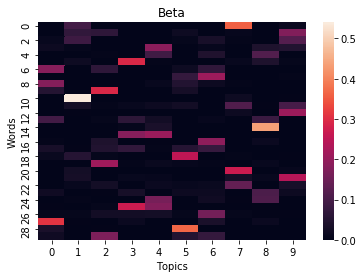

In [72]:
ax = sns.heatmap(L.beta)
ax.set_xlabel('Topics')
ax.set_ylabel('Words')
ax.set_title('Beta')

Text(0.5,1,'Gamma')

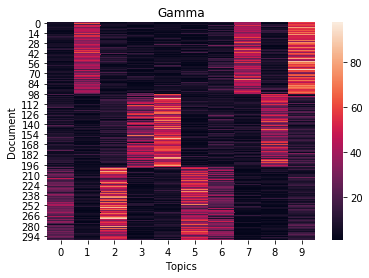

In [73]:
ax = sns.heatmap(L.gamma)
ax.set_xlabel('Topics')
ax.set_ylabel('Document')
ax.set_title('Gamma')